In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np
import re

In [2]:
root_fldr = 'runs\\v0.6'

In [3]:
def subdir_paths(folder):
    return [os.path.join(folder, f) for f in next(os.walk(folder))[1] if f != 'profiles']

meta_dfs = []
run_dfs = []
fldrs = subdir_paths(root_fldr)
for fldr in fldrs:
    print(fldr)
    sub_fldrs = subdir_paths(fldr)
    for sub_fldr in sub_fldrs:
        data_fldrs = subdir_paths(sub_fldr)
        for data_fldr in data_fldrs:
            meta_df = pd.read_csv(os.path.join(data_fldr, 'summary_stats.csv'))
            run_df = pd.read_csv(os.path.join(data_fldr, 'run_stats.csv'))
            meta_dfs.append(meta_df)
            run_dfs.append(run_df)
            
for key, df_list in {'summary': meta_dfs, 'run': run_dfs}.items():
    df = pd.concat(df_list)
    df['threshold_proportion'] = df['threshold_proportion'].fillna(0)
    df.to_csv(os.path.join(root_fldr, f'{key}_stats.csv'), index=False)
    
meta = pd.read_csv(os.path.join(root_fldr, 'summary_stats.csv'))
run = pd.read_csv(os.path.join(root_fldr, 'run_stats.csv'))

runs\v0.6\benchmark
runs\v0.6\sample


In [4]:
meta.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,remove_constraints,zero_slack_likelihood,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,iterative,auto,warm,1,0.0,False,0.0,100,0.5,0.2,fixed,1000,4950,12101,619.055620,590.847909,28.207711,506.0
1,0,iterative,auto,warm,1,0.0,True,0.0,100,0.5,0.2,fixed,1000,4950,6576,332.350982,278.236290,54.114692,506.0
2,0,iterative,auto,warm,1,0.0,True,0.1,100,0.5,0.2,fixed,1000,4950,7354,607.679773,546.540840,61.138933,506.0
3,0,iterative,auto,warm,1,0.0,True,0.3,100,0.5,0.2,fixed,1000,4950,6562,1111.021824,1020.450887,90.570937,506.0
4,1,iterative,auto,warm,1,0.0,False,0.0,100,0.5,0.2,fixed,1000,4950,11101,476.662479,450.395343,26.267137,514.0


In [5]:
run.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,remove_constraints,zero_slack_likelihood,sub_solve_id,n,...,cut_type,cut_value,cuts_sought,cuts_added,cuts_removed,search_proportion_used,current_threshold,variables,constraints,cpu_time
0,0,iterative,auto,warm,1,0.0,False,0.0,0,100,...,fixed,1000,100,100,0,1,NaN,4950,101,0.010421
1,0,iterative,auto,warm,1,0.0,False,0.0,1,100,...,fixed,1000,1000,1000,0,1,NaN,4950,1101,0.044184
2,0,iterative,auto,warm,1,0.0,False,0.0,2,100,...,fixed,1000,1000,1000,0,1,NaN,4950,2101,0.047701
3,0,iterative,auto,warm,1,0.0,False,0.0,3,100,...,fixed,1000,1000,1000,0,1,NaN,4950,3101,0.168431
4,0,iterative,auto,warm,1,0.0,False,0.0,4,100,...,fixed,1000,1000,1000,0,1,NaN,4950,4101,2.857392


In [6]:
def cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, max_n):
    run_map = {
        'once_False_0.0': 'single solve',
        'iterative_False_0.0': 'no removals',
        'iterative_True_0.0': 'remove slack',
        'iterative_True_0.1': '10% nonslack',
        'iterative_True_0.3': '30% nonslack',
    }
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'n', 'solve_type', 'remove_constraints', 'zero_slack_likelihood'])[col_selection].mean().reset_index()
    gd['concat'] = gd['solve_type'] + '_' + gd['remove_constraints'].astype(str) + '_' + gd['zero_slack_likelihood'].astype(str)
    gd['idx'] = gd['concat'].map(run_map)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            # filter out ignored patterns and those not in accepted patterns
            if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
            # assign line style to group
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], label=name)
                plt.ylabel('proportion_of_cpu_time')
            else:
                plt.plot(subset['n'], subset[col_selection], label=name)
                plt.ylabel('cpu_time')

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.xlabel('n')
        plt.legend()
        plt.rcParams['figure.figsize'] = [8, 8]
        plt.show()

## Settings

In [9]:
ignored_patterns = []
accepted_patterns = []

max_n = 150
time_measure = 'total_cpu_time'

## Total CPU Time

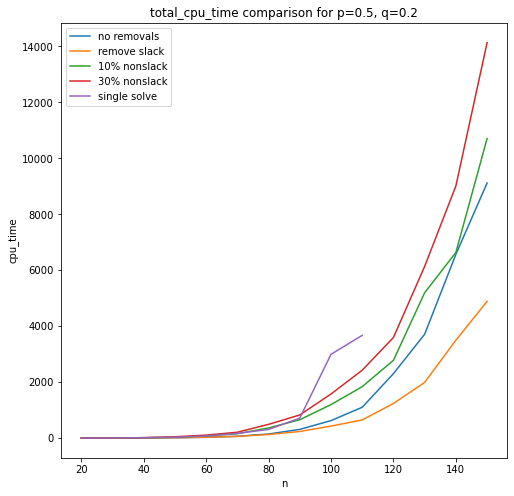

In [10]:
time_measure = 'total_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, max_n)

## Gurobi CPU Time

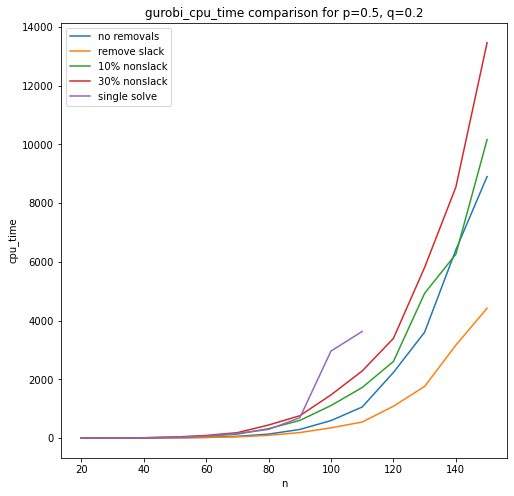

In [11]:
time_measure = 'gurobi_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, max_n)

## Proportion CPU Time Gurobi

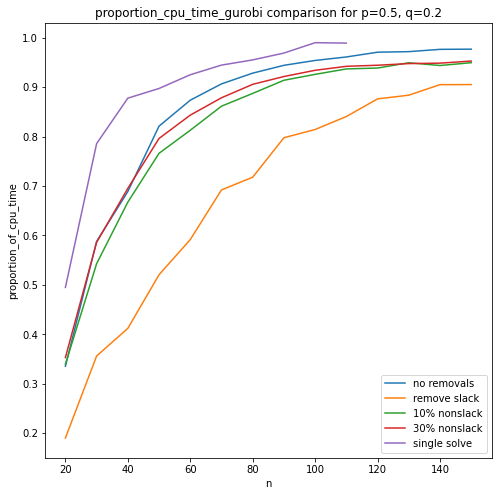

In [12]:
time_measure = 'proportion_cpu_time_gurobi'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, max_n)

## Number of Max Constraints

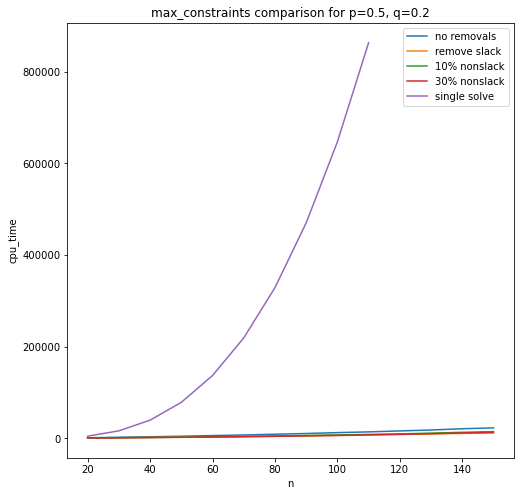

In [13]:
time_measure = 'max_constraints'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, max_n)

## Number of LP's per Solve

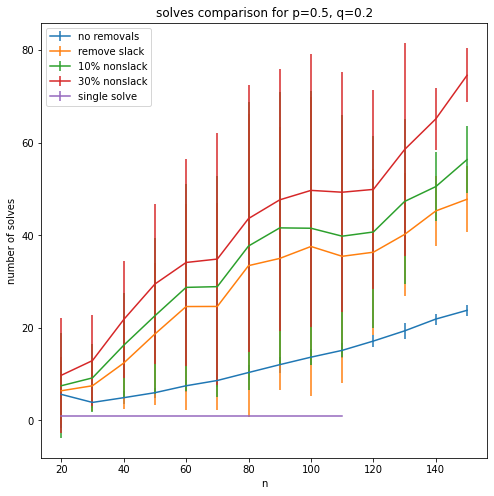

In [15]:
# Get number of runs from each solve
gd = run.groupby(['p', 'q', 'solve_id', 'n', 'solve_type', 'remove_constraints', 'zero_slack_likelihood'])['sub_solve_id'].max().reset_index()

# rename and adjust for 0 indexing
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# get average and std for each unique run combination
gd = gd.groupby(['p', 'q', 'n', 'solve_type', 'remove_constraints', 'zero_slack_likelihood'], as_index=False).agg({'solves': ['mean','std']})
gd.columns = [f'{i}_{j}' if j else i for i, j in gd.columns]

# create id
run_map = {
        'once_False_0.0': 'single solve',
        'iterative_False_0.0': 'no removals',
        'iterative_True_0.0': 'remove slack',
        'iterative_True_0.1': '10% nonslack',
        'iterative_True_0.3': '30% nonslack',
    }
gd['concat'] = gd['solve_type'] + '_' + gd['remove_constraints'].astype(str) + '_' + gd['zero_slack_likelihood'].astype(str)
gd['idx'] = gd['concat'].map(run_map)

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
        # assign line style to group
        plt.errorbar(subset['n'], subset['solves_mean'], subset['solves_std'], label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('number of solves')
    plt.xlabel('n')
    plt.legend()
    plt.show()